# Installs

In [ ]:
! pip install -q ucimlrepo

# Imports

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


# Framework
import torch

# Data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset

# For creating neural networks
import torch.nn as nn
import torch.nn.functional as F

# For optimizing neural networks
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# For metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error
from torchsummary import summary

# For dataset loading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from ucimlrepo import fetch_ucirepo

from tqdm.notebook import tqdm, trange

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cuda


# Set seed

In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Load dataset

In [4]:
df = fetch_ucirepo(id=275).data.original
print(f"Dataset shape: {df.shape}")

Dataset shape: (17379, 17)


# EDA and pre-processing

Dropping `instant` and `dteday` as they are essentially indices for the data and are not useful in calculations.

In [5]:
df.drop(columns=['instant', 'dteday'], inplace=True)

Check for null and duplicate values and drop the rows

In [6]:
print(f"Duplicate rows in the dataset: {df.duplicated().sum()}")
print(f"Null rows in the dataset:\n{df.isnull().sum()}")
df = df.drop_duplicates()
df = df.dropna()

Duplicate rows in the dataset: 2
Null rows in the dataset:
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


One hot encode all the categorical features

In [7]:
df = pd.get_dummies(df, columns=['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit'], dtype=float)
df.shape

(17377, 62)

# Dataset splitting

In [8]:
X = df.drop(columns=['cnt'])
y = df['cnt']

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_test), len(X_val), len(X)

(12163, 2607, 2607, 17377)

## Scale data

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Convert to pytorch tensors

In [11]:
# Convert to torch tensors because PyTorch's deep learning models and operations require tensors as inputs.
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_torch = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_torch = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## Create dataloaders

In [12]:
# Create TensorDatasets for training, validation, and testing data
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Define batch size
batch_size = 1024

# Create DataLoaders for training, validation, and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network

In [13]:
# Define the fully connected neural network
class DigitsNet(nn.Module):
    def __init__(self):
        super(DigitsNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 64)          # Hidden layer 2
        self.fc3 = nn.Linear(64, 32)           # Hidden layer 3
        self.fc4 = nn.Linear(32, 16)           # Hidden layer 4
        self.fc5 = nn.Linear(16, 1)            # Output layer (1 output, regression problem)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x)) # ReLU activation for output layer as well as the output layer is the count of bicycles rented and that cannot be negative.
        x = self.fc5(x)
        return x

# Training

In [14]:
lr_history = []

def train_and_evaluate_regression(model, learning_rate, trainloader, valloader, testloader, optimizer, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in trange(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in tqdm(trainloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, labels) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(valloader, leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)

        val_loss /= total
        val_loss_history.append(val_loss)

        if (epoch + 1) % 10 == 0:
            tqdm.write(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        if len(lr_history) > 1 and current_lr != lr_history[-2]:
            tqdm.write(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                tqdm.write("Early stopping triggered.")
                break
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            r2 = r2_score(all_labels, all_preds)
            mse = mean_squared_error(all_labels, all_preds)

    return train_loss_history, val_loss_history, r2, mse, all_preds, all_labels

## With custom Adam

In [15]:
class AdamOptimizer(Optimizer):
    def __init__(self, parameters, lr=0.01, rho_1=0.9, rho_2=0.9, epsilon=1e-10):
        defaults = {
            'lr': lr,
            'rho_1': rho_1,
            'rho_2': rho_2,
            'epsilon': epsilon
        }
        super().__init__(parameters, defaults)

    def step(self):
        with torch.no_grad():
            for group in self.param_groups:
                rho_1 = group['rho_1']
                rho_2 = group['rho_2']
                epsilon = group['epsilon']
                lr = group['lr']

                for p in group['params']:
                    if p.grad is None:
                        continue
                    
                    grad = p.grad
                    
                    state = self.state[p]
                    if len(state) == 0:
                        state['step'] = 0
                        state['A'] = torch.zeros_like(p)
                        state['F'] = torch.zeros_like(p)

                    state['step'] += 1
                    t = state['step'] # Storing time step as it is required for bias correction
                    A = state['A']
                    F = state['F']

                    # A_i <- rho_1 * A_i + (1 - rho_1) * (grad)^2
                    # A.mul_(rho_1) = A * rho_1
                    # result.addcmul_(grad, grad, value=1 - rho_1) = result + (1 - rho_1) * grad * grad
                    A.mul_(rho_1).addcmul_(grad, grad, value=1 - rho_1)

                    # F_i <- rho_2 * F_i + (1 - rho_2) * grad
                    F.mul_(rho_2).add_(grad, alpha=1 - rho_2)

                    # Bias Correction
                    # A_hat = A_i / (1 - rho_1^t)
                    # F_hat = F_i / (1 - rho_2^t)
                    bias_correction_1 = 1 - rho_1 ** t
                    bias_correction_2 = 1 - rho_2 ** t
                    
                    A_hat = A / bias_correction_1
                    F_hat = F / bias_correction_2

                    # Parameter Update
                    # theta <- theta - (alpha / sqrt(A_hat + epsilon)) * F_hat
                    denominator = (A_hat + epsilon).sqrt()
                    
                    step_size = lr / denominator
                    
                    p.sub_(step_size * F_hat)

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()

In [16]:
# Initialize the model
net = DigitsNet()
net = net.to(device)

learning_rate = 1e-1
optimizer = AdamOptimizer(net.parameters(), lr=learning_rate)

# Train the model with different learning rates and store the results

train_loss, val_loss, r2, mse, all_preds, all_labels = train_and_evaluate_regression(net, learning_rate, trainloader, valloader, testloader, optimizer, epochs=70)
result = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'r2_score': r2,
    'mse': mse
}

print(f'Final R2 Score on Test Set with custom adam: {result["r2_score"]:.4f}')
print(f'Final MSE on Test Set with custom adam: {result["mse"]:.4f}')

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/70], Train Loss: 536.0406, Validation Loss: 495.6287


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [20/70], Train Loss: 324.0434, Validation Loss: 85.3702


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Updated learning rate after epoch 23: 0.010000


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [30/70], Train Loss: 17.4995, Validation Loss: 20.3224


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [40/70], Train Loss: 10.7963, Validation Loss: 14.5938


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [50/70], Train Loss: 6.1978, Validation Loss: 10.4091


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Updated learning rate after epoch 51: 0.001000


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [60/70], Train Loss: 3.5173, Validation Loss: 8.2848


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [70/70], Train Loss: 3.2759, Validation Loss: 7.8830


  0%|          | 0/3 [00:00<?, ?it/s]

Final R2 Score on Test Set with custom adam: 0.9997
Final MSE on Test Set with custom adam: 7.7674


## Plots

### Loss curve

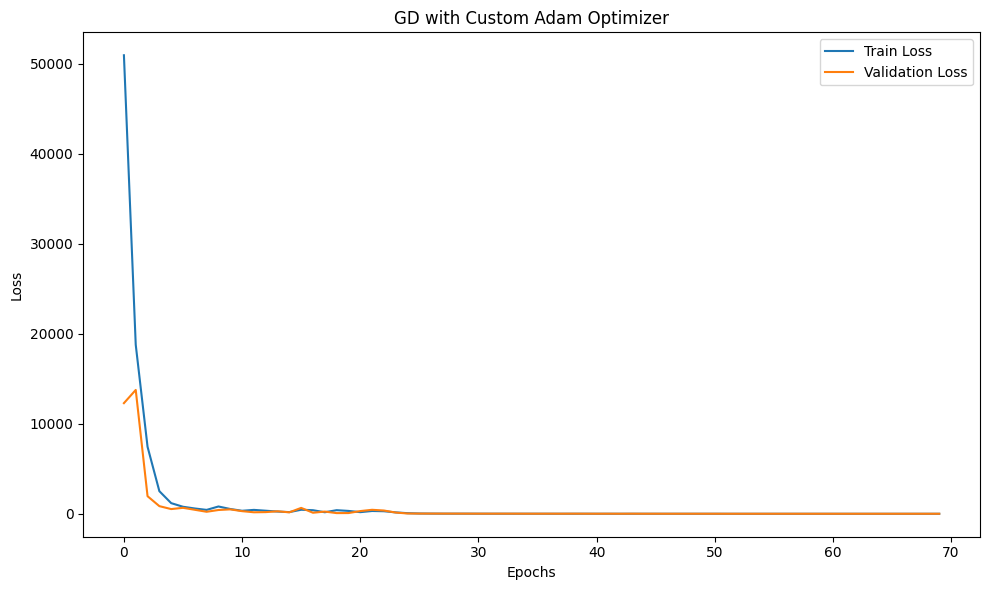

In [17]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('GD with Custom Adam Optimizer')

plt.plot(result['train_loss'], label=f'Train Loss')
plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Scatter plot

C:\Users\shamb\AppData\Local\Temp\ipykernel_22252\4155779385.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


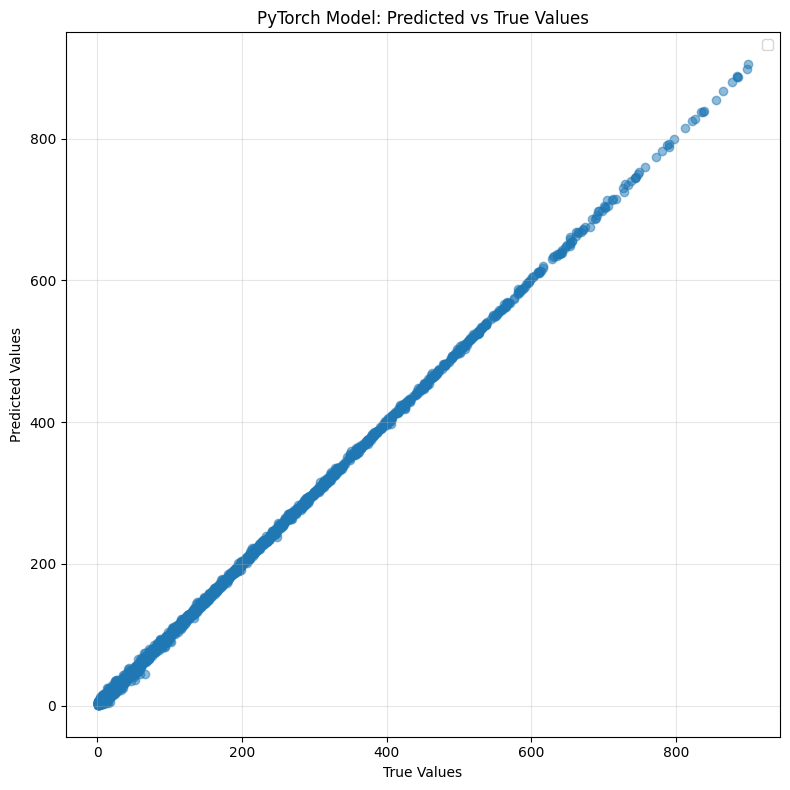

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('PyTorch Model: Predicted vs True Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## With PyTorch Adam

In [19]:
# Initialize the model
net = DigitsNet()
net = net.to(device)

learning_rate = 1e-1
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Train the model with different learning rates and store the results

train_loss, val_loss, r2, mse, all_preds, all_labels = train_and_evaluate_regression(net, learning_rate, trainloader, valloader, testloader, optimizer, epochs=70)
result = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'r2_score': r2,
    'mse': mse
}

print(f'Final R2 Score on Test Set with pytorch adam: {result["r2_score"]:.4f}')
print(f'Final MSE on Test Set with pytorch adam: {result["mse"]:.4f}')

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Updated learning rate after epoch 1: 0.100000


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/70], Train Loss: 215.7115, Validation Loss: 212.3263


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [20/70], Train Loss: 70.8014, Validation Loss: 78.1586


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [30/70], Train Loss: 34.2119, Validation Loss: 44.3359


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [40/70], Train Loss: 20.7412, Validation Loss: 27.9968


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [50/70], Train Loss: 14.6190, Validation Loss: 19.4302


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [60/70], Train Loss: 10.2993, Validation Loss: 14.1509


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [70/70], Train Loss: 7.8569, Validation Loss: 11.2186


  0%|          | 0/3 [00:00<?, ?it/s]

Final R2 Score on Test Set with pytorch adam: 0.9996
Final MSE on Test Set with pytorch adam: 11.7084


# Plot

### Loss curve

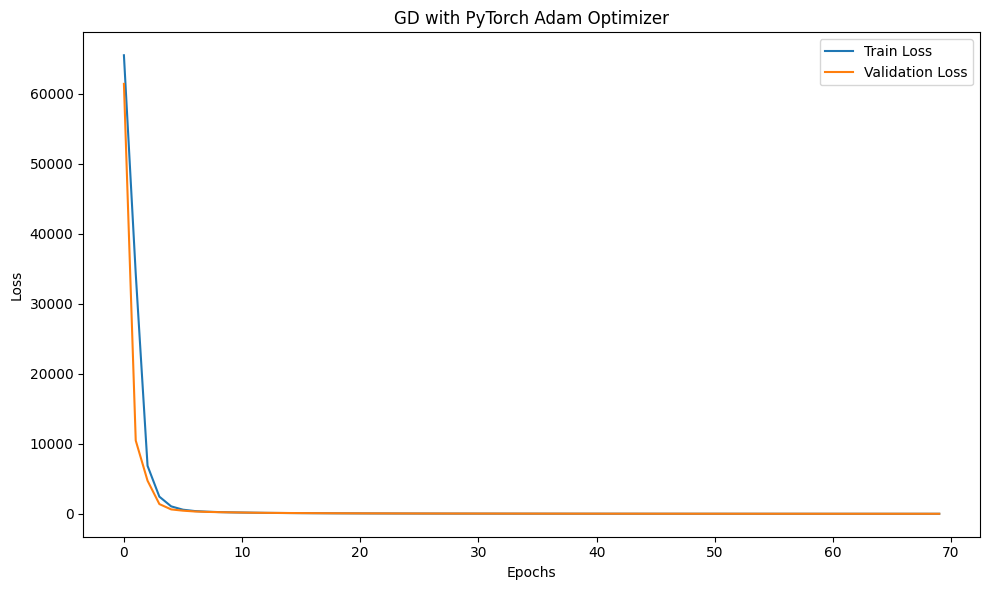

In [20]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('GD with PyTorch Adam Optimizer')

plt.plot(result['train_loss'], label=f'Train Loss')
plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Scatter plot

C:\Users\shamb\AppData\Local\Temp\ipykernel_22252\4155779385.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


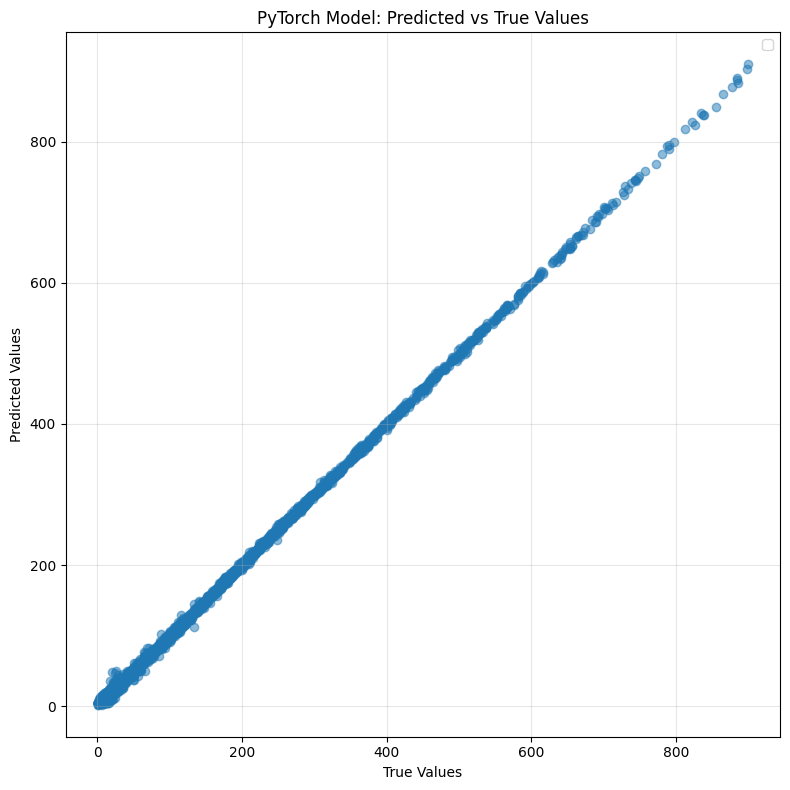

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('PyTorch Model: Predicted vs True Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()